This is the final project for GLBL 5050 - Introduction to Python for Global Affairs. 

This project will look at humanitarian aid in the recent conflict in the Gaza Strip between Israeli military forces and Hamas. We will analyze different aspects of humanitarian aid including what aid/resrouces are entering the areas of conflict and through what means (crossings) and reports of KIKA (Killed, injured, kidnapped, or arrested)incidents with humanitarian aid workers in this area. 

[Further analysis may also include donors of aid... 

In [412]:
!pip install openpyxl

In [414]:
!pip install geopandas matplotlib pandas

In [416]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt


In [418]:

!pip install pyproj --only-binary :all:

!pip install geopandas


In [419]:
import geopandas as gpd

In [422]:

commodities = pd.read_excel('Commodities_Received.xlsx', engine='openpyxl')

#print(commodities.head())
#commodities.shape


PART I. Tracking resources by crossing throughout time 

line graph. Dates on the x axis, numbers of trucks/day on the y axis. different colors for different crossings 

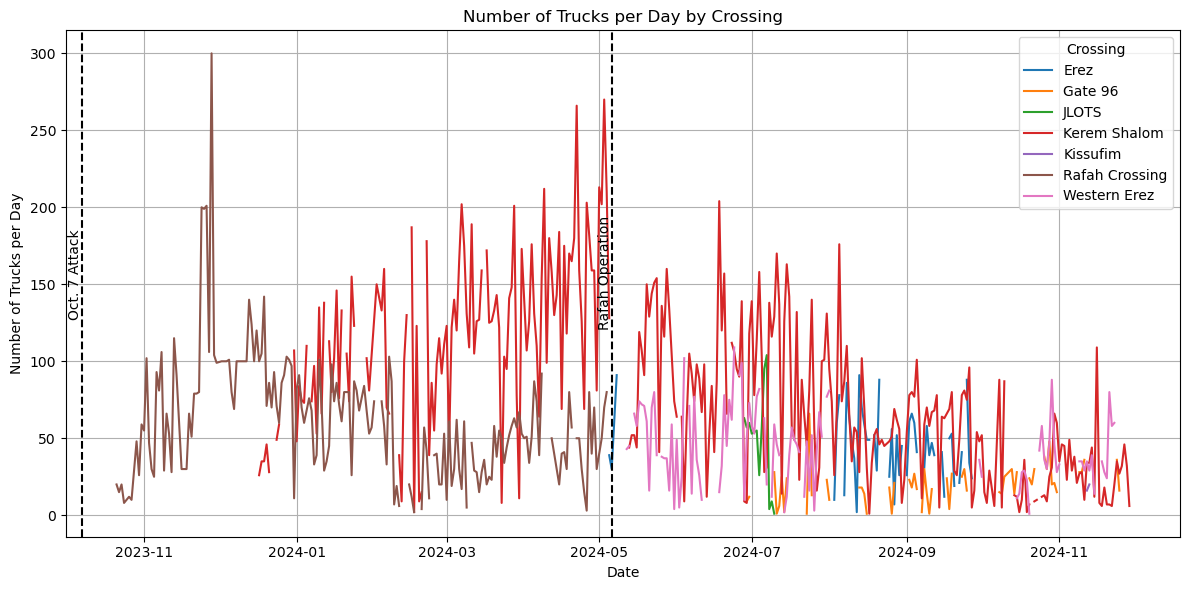

In [424]:
# Data preprocessing
# Convert the date column to datetime format
commodities['Received Date'] = pd.to_datetime(commodities['Received Date'])

# Group by date and crossing, summing the number of trucks
grouped_data = commodities.groupby(['Received Date', 'Crossing'])['No. of Trucks'].sum().reset_index()

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='Received Date', columns='Crossing', values='No. of Trucks')

# Plotting
plt.figure(figsize=(12, 6))
for crossing in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[crossing], label=crossing)

# Customize the plot
plt.title('Number of Trucks per Day by Crossing')
plt.xlabel('Date')
plt.ylabel('Number of Trucks per Day')
plt.legend(title='Crossing')
plt.grid()
plt.tight_layout()

## ADD Oct. 7, Hamas attack 
plt.axvline(pd.Timestamp('2023-10-07'), color='black', linestyle='--', label='Oct. 7 Attack ')
plt.text(pd.Timestamp('2023-10-07'), plt.ylim()[1] / 2, 'Oct. 7 Attack ', color='black', 
         rotation=90, verticalalignment='center', horizontalalignment='right')

## ADD Rafah Operation Date 
plt.axvline(pd.Timestamp('2024-05-06'), color='black', linestyle='--', label='Rafah Operation')
plt.text(pd.Timestamp('2024-05-06'), plt.ylim()[1] / 2, 'Rafah Operation', color='black', 
         rotation=90, verticalalignment='center', horizontalalignment='right')

# Show the plot
plt.show()


PART II. Type of Cargo 

Bar chart. With amount of cargo by pallets, colors represent different types of cargo throughout time 
Dates (maybe by month) on x axis, bar chart of supply count, broken up to sections dependent on type of cargo 

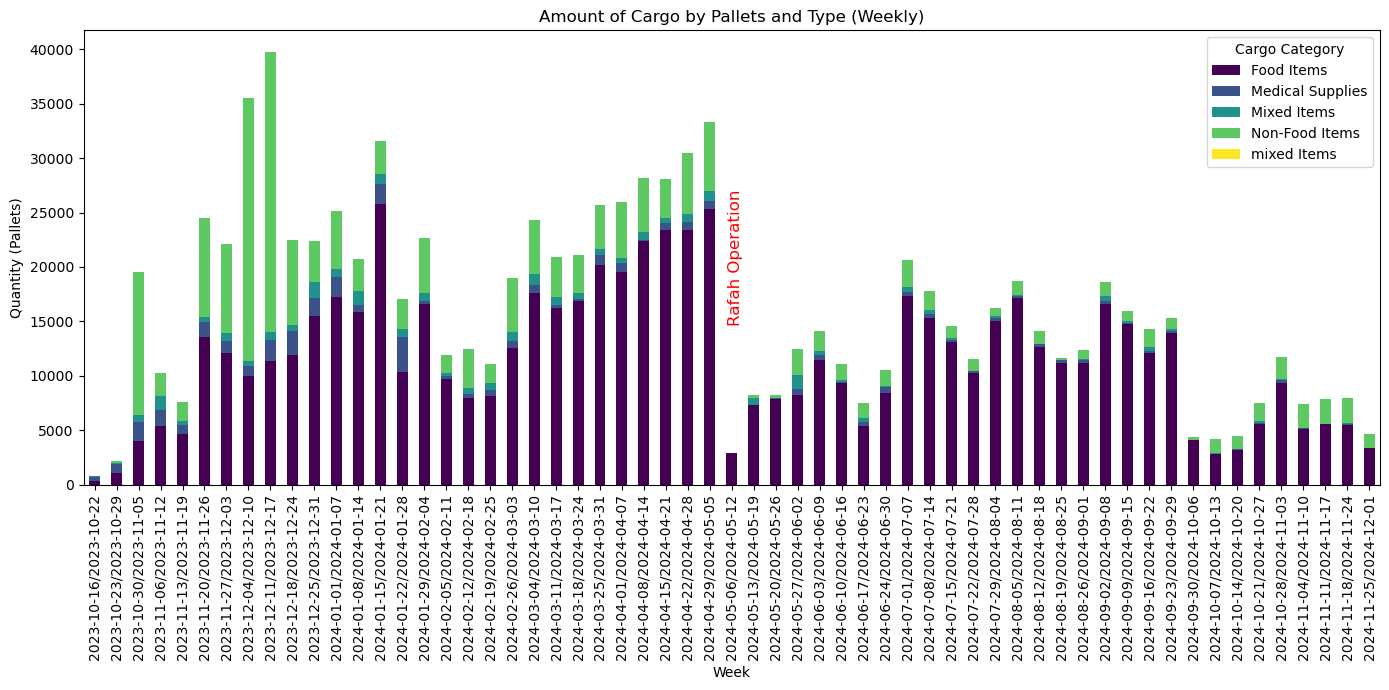

In [426]:
assert isinstance(commodities, pd.DataFrame), "Data is not a DataFrame. Please check the input."
commodities['Week'] = commodities['Received Date'].dt.to_period('W')

# Group by week and cargo type, summing the quantity in pallets
cargo_data = commodities.groupby(['Week', 'Cargo Category'])['Quantity'].sum().reset_index()

# Pivot the data for stacked bar chart
cargo_pivot = cargo_data.pivot(index='Week', columns='Cargo Category', values='Quantity').fillna(0)

# Plotting the stacked bar chart
#cargo_pivot.index = cargo_pivot.index.to_timestamp()
cargo_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis')


y_min, y_max = plt.ylim()
y_middle = (y_min + y_max) / 2

# ## ADD Rafah Operation Date 
# plt.text(pd.Timestamp('2024-05-06/2024-05-12'), y_middle, 'Rafah Operation', color='red', 
#          rotation=90, verticalalignment='center', horizontalalignment='right')
plt.annotate(
    'Rafah Operation',  # Text to display
    xy=(50, plt.ylim()[1] / 2),  # Replace '20' with the x-axis location (numerical index)
    xytext=(29.5, y_middle),  # Replace '15' with the desired x position for the text
    rotation=90,
    color='red',  # Text color
    fontsize=12,  # Font size
    ha='right',  # Horizontal alignment
    va='center'   # Vertical alignment
)
# Customize the plot
plt.title('Amount of Cargo by Pallets and Type (Weekly)')
plt.xlabel('Week')
plt.ylabel('Quantity (Pallets)')
plt.legend(title='Cargo Category')
plt.tight_layout()

# Show the plot
plt.show()


PART III. Donating country/organization 

similar bar chart to above showing who/what organization donated the supplies 


In [428]:
print("Donating Country/Organization")

## find the different donors using unique function. 
donors = commodities['Donating Country/ Organization'].unique()
#print(donors)

## There are too many different individual donors. Let's find out which organizations are the biggest donors, and group the rest. 
## Private sector could probably be grouped together as they are a large donor, with some specficiations in the dataset. 

# Extract the "Donating Country/Organization" column
donor_counts = commodities['Donating Country/ Organization'].value_counts()

# Create a dataframe with the donor names and the counts of donations.
# Note: the dataset used two metrics. One counts number of trucks, the other uses MT (metric tons) and pallets. For this analysis, we will use number of trucks as we do not know the conversion for pallets to metric tons. 
donor_df = pd.DataFrame({
    'Donor': donor_counts.index,
    'Count': donor_counts.values
})

# In the dataset, we see a couple of donors who are the same donor country/organization but are entered in different syntaxes. For example, the country of Turkey has "Turkey", "TURKEY", and "Turkey "
# Preprocess donor names: Remove spaces, lowercase, and strip extra characters, then combine occurrences for matching donors. For example, adding together all the "turkey" donations 
processed_data = {}
for donor, count in zip(donor_df['Donor'], donor_df['Count']):
    if isinstance(donor, str):  # Ran into coding error as some are not strings? I believe it may be the use of "+" symbols in the donor names. 
        normalized_name = donor.strip().replace(" ", "").lower() # Getting rid of spaces... see Turkey example 
        processed_data[normalized_name] = processed_data.get(normalized_name, 0) + count  ## adding them up 

# Create a new dataframe from the processed data, again issues with having the same donor under different names 
processed_df = pd.DataFrame(list(processed_data.items()), columns=['Normalized Donor', 'Total Count'])

# Filter donors with >250 occurrences - There are too many donors to put on a chart/graph. Let's consolidate the not so important ones. So we set notable donors as donors who have donated more than 250 trucks of resources.
notable_donors = processed_df[processed_df['Total Count'] > 250]

# Categorize remaining donors - But make sure we don't lose the rest of the donors. We will categorize these remaining donors into a couple of categories, including countries (but not the ones > 250 trucks), other aid organizations, and adding all the loose private sector donations into the main private sector donor group. 
remaining_donors = processed_df[processed_df['Total Count'] <= 250]

# Define country list, looked through dataset for country donors. 
country_list = ["turkey", "saudiarabia", "uae", "qatar", "kuwait", "egypt", "jordan", "oman", "pakistan", "india", "france", "germany", "canada", "china", "russia", "brazil", "indonesia", "malaysia", "australia", "italy", "spain", "romania", "bahrain", "libya", "algeria", "tunisia", "morocco", "iraq"]

# Initialize counts for categories
other_countries_count = 0
private_sector_count = 0
other_aid_organizations_count = 0

# Categorize remaining donors
for _, row in remaining_donors.iterrows():
    normalized_name = row['Normalized Donor']
    count = row['Total Count']

    if any(country in normalized_name for country in country_list):
        other_countries_count += count
    elif "privatesector" in normalized_name:
        private_sector_count += count
    else:
        other_aid_organizations_count += count

## Right now, output separates the private sector and other categories from the main ranking as they are not part of the notable donors dataframe, so let's append them to it 
# Add private sector count to notable donors
private_sector_index = notable_donors[notable_donors['Normalized Donor'] == 'privatesector'].index
if not private_sector_index.empty:
    notable_donors.loc[private_sector_index, 'Total Count'] += private_sector_count
else:
    notable_donors = pd.concat([notable_donors, pd.DataFrame({
        'Normalized Donor': ['privatesector'],
        'Total Count': [private_sector_count]
    })], ignore_index=True)

# Add other categories to notable donors
notable_donors = pd.concat([notable_donors, pd.DataFrame({
    'Normalized Donor': ['othercountries', 'otheraidorganizations'],
    'Total Count': [other_countries_count, other_aid_organizations_count]
})], ignore_index=True)

## RENAMING back to original names, for display purposes 
rename_mapping = {
    'privatesector': 'Private Sector',
    'wfp': 'WFP',
    'unrwa': 'UNRWA',
    'erc': 'ERC',
    'otheraidorganizations': 'Other Aid Organizations',
    'wck': 'WCK',
    'othercountries': 'Other Countries',
    'unicef': 'UNICEF',
    'rww': 'RWW',
    'anera': 'ANERA',
    'turkey': 'Turkey',
    'icrc': 'ICRC',
    'uae': 'UAE',
    'saudiarabia': 'Saudi Arabia',
    'iom': 'IOM',
    'jhco': 'JHCO',
    'who': 'WHO'
}
notable_donors['Normalized Donor'] = notable_donors['Normalized Donor'].apply(lambda x: rename_mapping.get(x, x))

# Sort all notable donors by the count in descending order
notable_donors = notable_donors.sort_values(by='Total Count', ascending=False).reset_index(drop=True)

# Output results
print("Ranked Notable Donors:")
print(notable_donors)



## -------------------------------NOTES--------------------------------------------------------------
# Print the sorted list by occurrences
# print("Donors (sorted by quantity decreasing):")
# for donor, count in donor_list_sorted:
#     print(f"{donor}: {count}")

## Now that we have a list of donors, let's clean the dataset 
## Consolidating private sector donors, combining countries < 250 donations, other organizations, etc. 

# If private sector in name, (make sure to lowercase all), then add to All_Private_Sector 

# Create country list, append to {country !select few} --> All_Other_Countries
# Select few being --> Turkey, UAE, Saudi Arabia 

# Other aid organization. Create list. And append to {Other_Aid_Organizations} 


Donating Country/Organization
Ranked Notable Donors:
           Normalized Donor  Total Count
0            Private Sector        10284
1                       WFP         9728
2                     UNRWA         8539
3                       ERC         5874
4   Other Aid Organizations         2405
5                       WCK         1629
6           Other Countries         1506
7                    UNICEF         1104
8                       RWW         1039
9                     ANERA          829
10                   Turkey          808
11                     ICRC          464
12                      UAE          437
13             Saudi Arabia          375
14                      IOM          359
15                     JHCO          326
16                      WHO          260


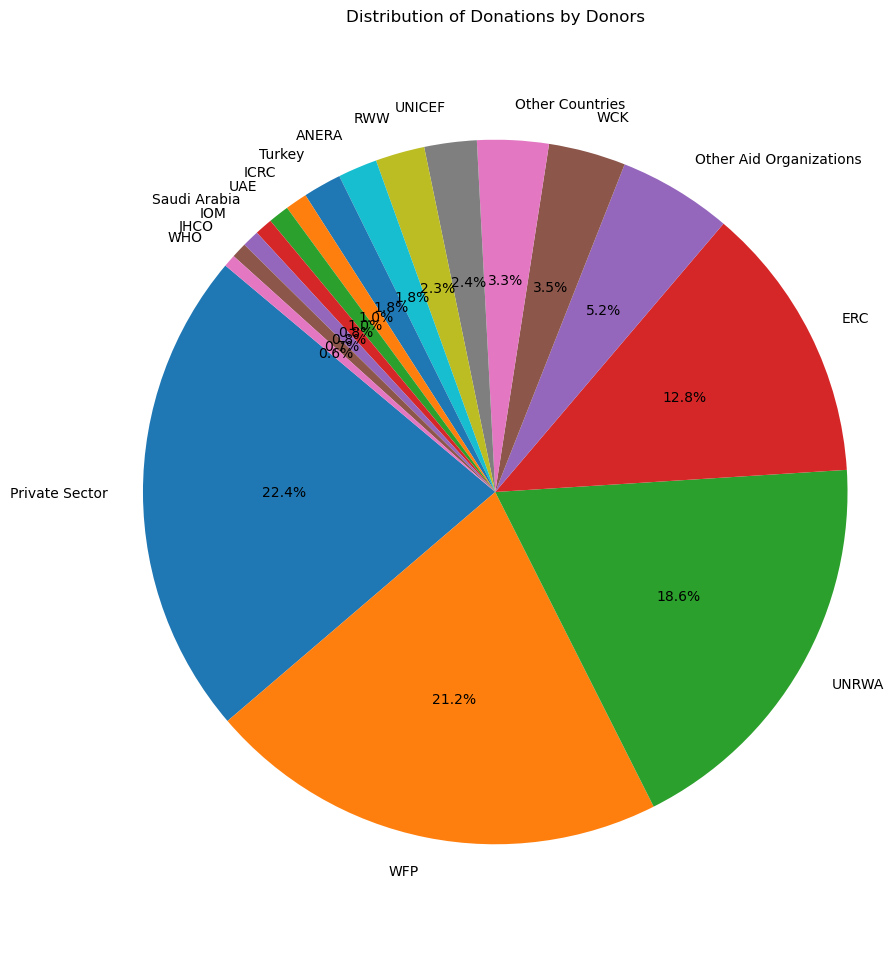

In [354]:

## Now that we have the results, lets create a pie chart and then a bar graph 
## PIE CHART: display total donations by donor 


# Create a pie chart
plt.figure(figsize=(10, 12))
plt.pie(
    notable_donors['Total Count'], 
    labels=notable_donors['Normalized Donor'], 
    autopct='%1.1f%%', 
    startangle=140
)
plt.title('Distribution of Donations by Donors')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [445]:
!pip install ace_tools


<Figure size 1400x700 with 0 Axes>

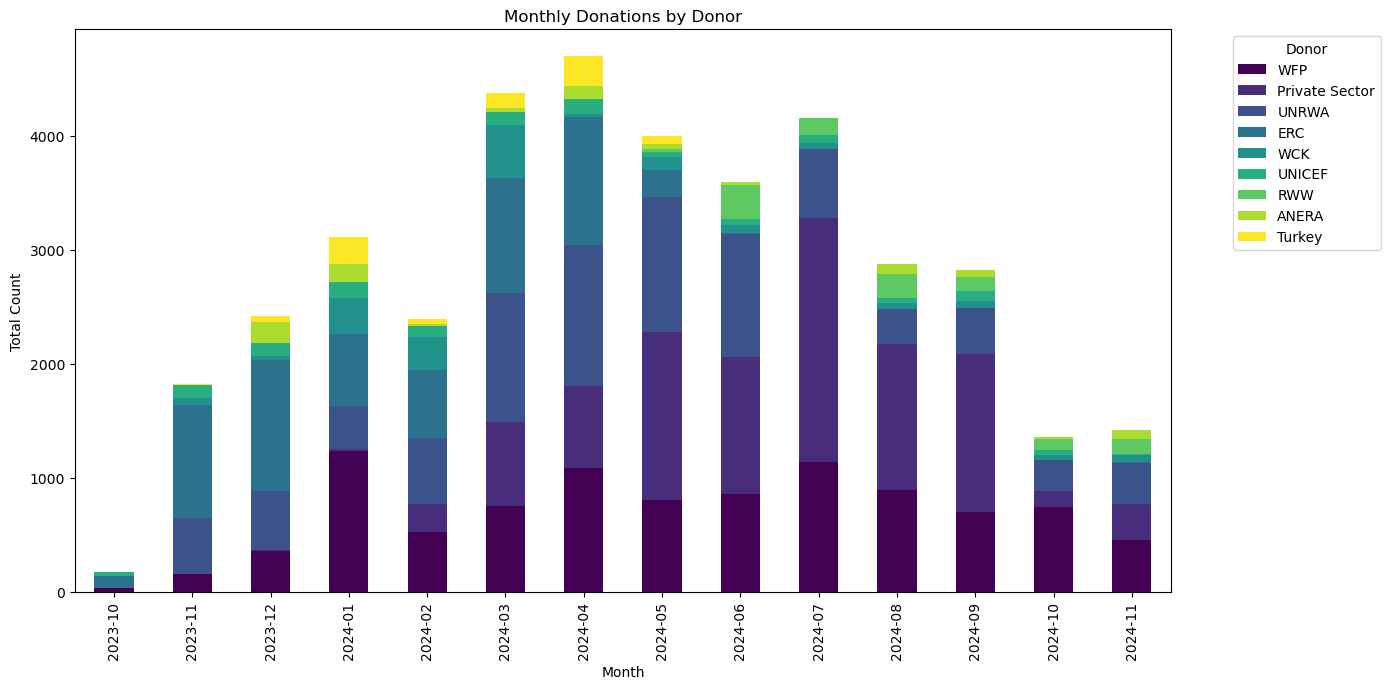

In [500]:

# PART III: Bar chart for Donating Country/Organization (Monthly)
# Group by donating country/organization and sum the quantity in pallets

## Additionaly Note: There were still too many donors in the barchart, we will increase the threshold for qualifying as a notable donor to 500 trucks in total. 


import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Normalize donor names in the dataset
commodities['Normalized Donor'] = commodities['Donating Country/ Organization'].str.strip().str.replace(" ", "").str.lower()

# Step 2: Count donations per donor and received date
donor_counts = commodities.groupby(['Normalized Donor', 'Received Date']).size().reset_index(name='Count')

# Step 3: Consolidate donor names and counts
processed_data = {}
for _, row in donor_counts.iterrows():
    donor = row['Normalized Donor']
    received_date = row['Received Date']
    count = row['Count']

    if donor not in processed_data:
        processed_data[donor] = {}

    if received_date not in processed_data[donor]:
        processed_data[donor][received_date] = 0

    processed_data[donor][received_date] += count

# Step 4: Flatten the processed data into a dataframe
flattened_data = []
for donor, dates in processed_data.items():
    for date, count in dates.items():
        flattened_data.append({'Normalized Donor': donor, 'Received Date': date, 'Total Count': count})
processed_df = pd.DataFrame(flattened_data)

# Step 5: Identify notable donors with >250 total contributions
notable_donors = processed_df.groupby('Normalized Donor')['Total Count'].sum().reset_index()
notable_donors = notable_donors[notable_donors['Total Count'] > 500]

# Filter the data for notable donors and group by day
daily_data = processed_df[processed_df['Normalized Donor'].isin(notable_donors['Normalized Donor'])]
daily_data = daily_data.groupby(['Received Date', 'Normalized Donor'])['Total Count'].sum().reset_index()

# Step 6: Categorize remaining donors
remaining_donors = processed_df.groupby('Normalized Donor')['Total Count'].sum().reset_index()
remaining_donors = remaining_donors[remaining_donors['Total Count'] <= 500]

# Define a list of recognized countries
country_list = ["turkey", "saudiarabia", "uae", "qatar", "kuwait", "egypt", "jordan", "oman", "pakistan", "india", "france", "germany", "canada", "china", "russia", "brazil", "indonesia", "malaysia", "australia", "italy", "spain", "romania", "bahrain", "libya", "algeria", "tunisia", "morocco", "iraq"]

# Initialize counts for other categories
other_countries_count = 0
private_sector_count = 0
other_aid_organizations_count = 0

# Categorize remaining donors
for _, row in remaining_donors.iterrows():
    normalized_name = row['Normalized Donor']
    count = row['Total Count']

    if any(country in normalized_name for country in country_list):
        other_countries_count += count
    elif "privatesector" in normalized_name:
        private_sector_count += count
    else:
        other_aid_organizations_count += count

# Step 7: Append private sector and other categories to notable donors
donor_summary = pd.concat([
    notable_donors,
    pd.DataFrame({
        'Normalized Donor': ['privatesector', 'othercountries', 'otheraidorganizations'],
        'Total Count': [private_sector_count, other_countries_count, other_aid_organizations_count]
    })
], ignore_index=True)

# Step 8: Rename donors for display purposes
rename_mapping = {
    'privatesector': 'Private Sector',
    'wfp': 'WFP',
    'unrwa': 'UNRWA',
    'erc': 'ERC',
    'otheraidorganizations': 'Other Aid Organizations',
    'wck': 'WCK',
    'othercountries': 'Other Countries',
    'unicef': 'UNICEF',
    'rww': 'RWW',
    'anera': 'ANERA',
    'turkey': 'Turkey',
    'icrc': 'ICRC',
    'uae': 'UAE',
    'saudiarabia': 'Saudi Arabia',
    'iom': 'IOM',
    'jhco': 'JHCO',
    'who': 'WHO'
    # Add other donor mappings as needed
}
daily_data['Normalized Donor'] = daily_data['Normalized Donor'].apply(lambda x: rename_mapping.get(x, x))

# Step 9: Output the daily data as a dataframe
daily_data = daily_data.sort_values(by=['Received Date', 'Normalized Donor']).reset_index(drop=True)
#print(daily_data)


# Step 10: Create a stacked bar chart for monthly donations
daily_data['Month'] = pd.to_datetime(daily_data['Received Date']).dt.to_period('M')
monthly_data = daily_data.groupby(['Month', 'Normalized Donor'])['Total Count'].sum().reset_index()
monthly_pivot = monthly_data.pivot(index='Month', columns='Normalized Donor', values='Total Count').fillna(0)

# Sort columns by total contributions to place largest contributors at the top
sorted_columns = monthly_pivot.sum(axis=0).sort_values(ascending=False).index
monthly_pivot = monthly_pivot[sorted_columns]

plt.figure(figsize=(14, 7))
monthly_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis')

# Customize the plot
plt.title('Monthly Donations by Donor')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.legend(title='Donor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()



PART IV. Comparing before and after Rafah Operation

Can compare donation type, donors, crossings. 

PART V. Visualizations



So we want to map these crossings and where the resources are going. 

For this part of the project, we will use another dataset named "commodities_dispatching" as it includes information about border crossings used by the trucks as well as the recipients of the supplies. Although we do not know exactly where in each city these recipient organizations are located, we can map out where aproximately they are going. 

In [604]:
commodities_2 = pd.read_excel('Commodities_Dispatching.xlsx', engine='openpyxl')


In [672]:
#print(commodities.head())

## Finding all the different crossings and destination recipient/partner. 
## Because there are so many different destination recipient/partners, we will sort them into a couple of broad locations. 

list(commodities_2)

print(commodities_2['Crossing'].unique())
print(commodities_2['Destination Recipient/ partner'].unique())

# Define the known locations
known_locations = [
    'Rafah', 'Khan Yunis', 'Deir Al-Balah', 'Nuseirat', 'Gaza City',
    'Geneina', 'Shaboura', 'Mall Al-Arab', 'Mawasi', 'Musabeh', 'Qatari Warehouse'
]

# Ensure the column is properly handled for missing or non-string values
commodities_2['Destination Recipient/ partner'] = commodities_2['Destination Recipient/ partner'].fillna('').astype(str)

# Classify each recipient into one of the known locations
commodities_2['Classified Location'] = commodities_2['Destination Recipient/ partner'].apply(
    lambda x: next((loc for loc in known_locations if loc in x), 'Unknown')
)

# Update all supplies going to GFO as Gaza City
commodities_2['Classified Location'] = commodities_2.apply(
    lambda row: 'Gaza City' if 'GFO' in row['Destination Recipient/ partner'] else row['Classified Location'], axis=1
)

# Verify the changes
updated_gaza_city = commodities_2[commodities_2['Classified Location'] == 'Gaza City']
print(updated_gaza_city[['Destination Recipient/ partner', 'Classified Location']].head())

# Optionally save the updated dataset
commodities_2.to_excel('updated_commodities.xlsx', index=False)

# Group the data by classified locations and count occurrences
sorted_locations = commodities_2.groupby('Classified Location')['Destination Recipient/ partner'].count().reset_index()

# Rename columns for better understanding
sorted_locations.columns = ['Classified Location', 'Count']

# Sort the DataFrame by count in descending order
sorted_locations = sorted_locations.sort_values(by='Count', ascending=False)

# Display the result
sorted_locations

['Kerem Shalom' 'Gate 96' 'Erez' 'Western Erez' 'Rafah' nan]
['KYTC Khan Younis WH' 'KYTC Khan Younis' 'Abu Elyan WH' ...
 'Mahmoud abu sita school / Khan Yonis' 'Social Affairs, Khan Younis'
 'MSF Khan Younis WH (West)']
     Destination Recipient/ partner Classified Location
1212                  GFO Warehouse           Gaza City
1213                  GFO Warehouse           Gaza City
1214                  GFO Warehouse           Gaza City
1215                  GFO Warehouse           Gaza City
1216                  GFO Warehouse           Gaza City


,Classified Location,Count
8,Rafah,18424
9,Unknown,6386
3,Khan Yunis,1758
0,Deir Al-Balah,1426
1,Gaza City,797
7,Nuseirat,127
2,Geneina,8
4,Mall Al-Arab,5
6,Musabeh,3
5,Mawasi,2


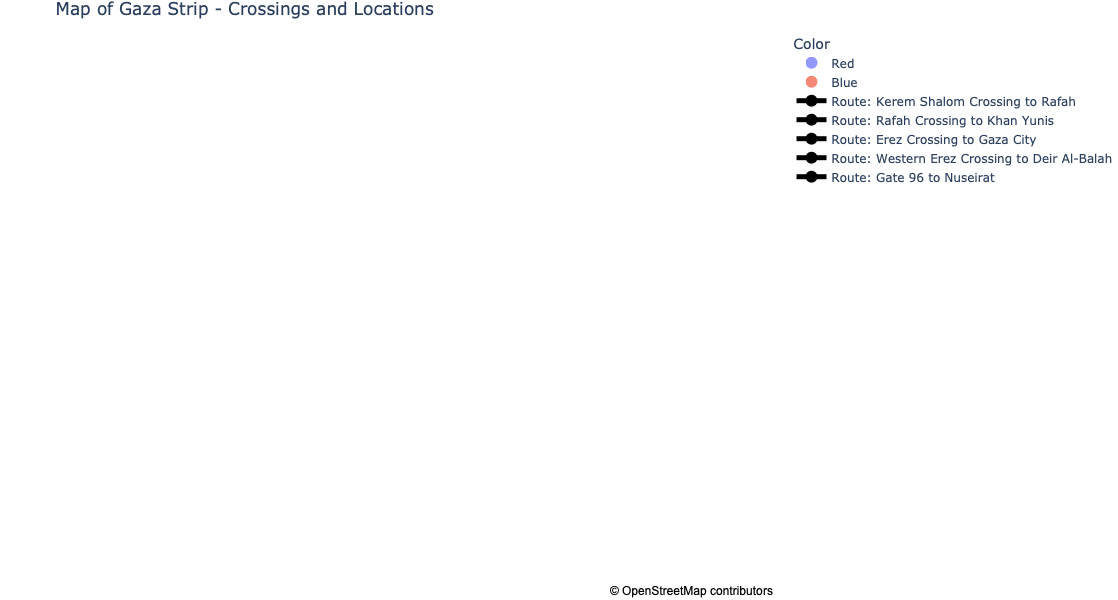

In [686]:
import plotly.express as px 

import plotly.express as px
import pandas as pd

# Create a dataset with locations in Gaza Strip
## LOCATIONS WE WANT TO INCLUDE 


import plotly.express as px
import pandas as pd

# Prepare data for crossings and locations
crossings_data = {
    'Location': [
        'Kerem Shalom Crossing', 'Rafah Crossing', 'Erez Crossing', 
        'Western Erez Crossing', 'Gate 96'
    ],
    'Latitude': [31.2200, 31.2504, 31.5350, 31.5300, 31.3400],
    'Longitude': [34.2950, 34.2442, 34.4900, 34.4800, 34.3700],
    'Color': ['Red'] * 5
}

locations_data = {
    'Location': [
        'Rafah', 'Khan Yunis', 'Deir Al-Balah', 'Nuseirat', 'Gaza City', 
        'Geneina', 'Shaboura', 'Mall Al-Arab', 'Mawasi', 'Musabeh', 'Qatari Warehouse'
    ],
    'Latitude': [
        31.2858, 31.3500, 31.4186, 31.4470, 31.5000, 
        31.2830, 31.2765, 31.2780, 31.3330, 31.2800, 31.3445
    ],
    'Longitude': [
        34.2406, 34.3050, 34.3500, 34.3900, 34.4667, 
        34.2460, 34.2448, 34.2480, 34.2730, 34.2500, 34.3663
    ],
    'Color': ['Blue'] * 11
}

# Combine the data
combined_data = {
    'Location': crossings_data['Location'] + locations_data['Location'],
    'Latitude': crossings_data['Latitude'] + locations_data['Latitude'],
    'Longitude': crossings_data['Longitude'] + locations_data['Longitude'],
    'Color': crossings_data['Color'] + locations_data['Color']
}

# Convert to a DataFrame
df = pd.DataFrame(combined_data)


df['Size'] = df['Color'].apply(lambda x: 8 if x == 'Red' else 4)  # Larger for crossings, smaller for locations

# Create the map
fig = px.scatter_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    text="Location",  # Show location names on the map
    color="Color",  # Color coding for crossings and locations
    size="Size",  # Adjust size of dots
    zoom=9,  # Adjust zoom for better visibility
    height=600,
    title="Map of Gaza Strip - Crossings and Locations"
)

# Add lines/arrows for routes
for route in routes:
    source = crossings_df[crossings_df['Location'] == route[0]]
    destination = locations_df[locations_df['Location'] == route[1]]
    
    if not source.empty and not destination.empty:
        fig.add_trace(go.Scattermapbox(
            lat=[source['Latitude'].values[0], destination['Latitude'].values[0]],
            lon=[source['Longitude'].values[0], destination['Longitude'].values[0]],
            mode='lines+markers',
            line=dict(width=2, color='black'),
            name=f"Route: {route[0]} to {route[1]}"
        ))

# Configure the map style
fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r": 0, "t": 30, "l": 0, "b": 0}  # Remove default margins
)

# Show the map
fig.show()





PART II: HUMANITARIAN AID WORKERS 

For this part of the analysis, we will be using the dataset named "KIKA_incidents" that reports the amount of humanitarian aid workers who were killed, injured, kidnapped, or arrested and the actors of these incidents. 


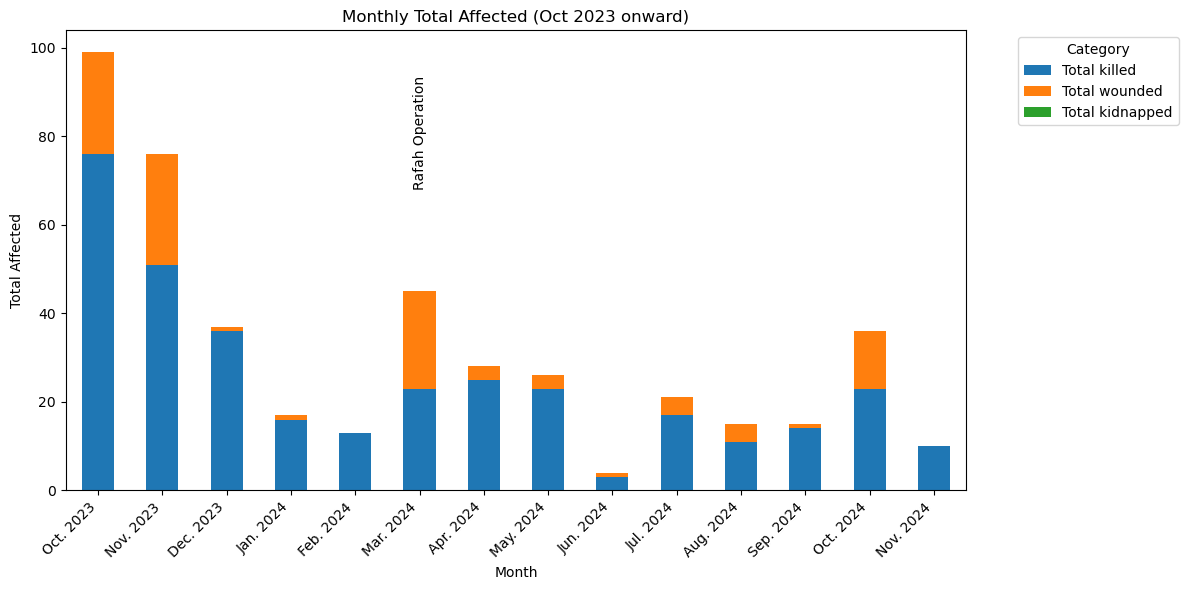

In [984]:

# Clean and preprocess the dataset
kika.columns = kika.columns.str.strip()  # Strip column names

# Convert 'Year', 'Month', and relevant columns to numeric, and filter from October 2023 onward
kika['Year'] = pd.to_numeric(kika['Year'], errors='coerce')
kika['Month'] = pd.to_numeric(kika['Month'], errors='coerce')
kika['Total killed'] = pd.to_numeric(kika['Total killed'], errors='coerce')
kika['Total wounded'] = pd.to_numeric(kika['Total wounded'], errors='coerce')
kika['Total kidnapped'] = pd.to_numeric(kika['Total kidnapped'], errors='coerce')

# Filter for October 2023 onward
kika = kika.dropna(subset=['Year', 'Month', 'Total killed', 'Total wounded', 'Total kidnapped'])
filtered_kika = kika[(kika['Year'] > 2023) | ((kika['Year'] == 2023) & (kika['Month'] >= 10))].copy()

# Aggregate total affected by month for the specified columns
filtered_kika['Date'] = pd.to_datetime(filtered_kika[['Year', 'Month']].assign(Day=1))
monthly_data = filtered_kika.groupby('Date')[['Total killed', 'Total wounded', 'Total kidnapped']].sum().reset_index()

# Plot the stacked bar chart
ax = monthly_data.set_index('Date').plot(kind='bar', stacked=True, figsize=(12, 6))

# Add a vertical line for "Rafah Operation" on March 2024
rafah_date = pd.Timestamp('2024-03-01')  # Define the date for the Rafah Operation
rafah_index = monthly_data[monthly_data['Date'] == rafah_date].index[0]  # Get the index of the date
plt.text(rafah_index, ax.get_ylim()[1] * 0.9, 'Rafah Operation', color='black', rotation=90, ha='center', va='top')


# Format x-axis with month and year as 'Oct. 2023', 'Nov. 2024', etc.
ax.set_xticks(range(len(monthly_data['Date'])))
ax.set_xticklabels(monthly_data['Date'].dt.strftime('%b. %Y'), rotation=45, ha='right')

# Add labels and legend
plt.title('Monthly Total Affected (Oct 2023 onward)')
plt.xlabel('Month')
plt.ylabel('Total Affected')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [914]:
kika = pd.read_csv('KIKA_incidents.csv')

print(kika['Actor name'].unique())


['#group+name+i_en' 'Unknown' 'Not applicable'
 'Israel Defense Forces (IDF)' 'Israeli Settlers'
 'Israeli Defence Forces (IDF)' 'Isreali Defence Forces (IDF)' 'Hamas']


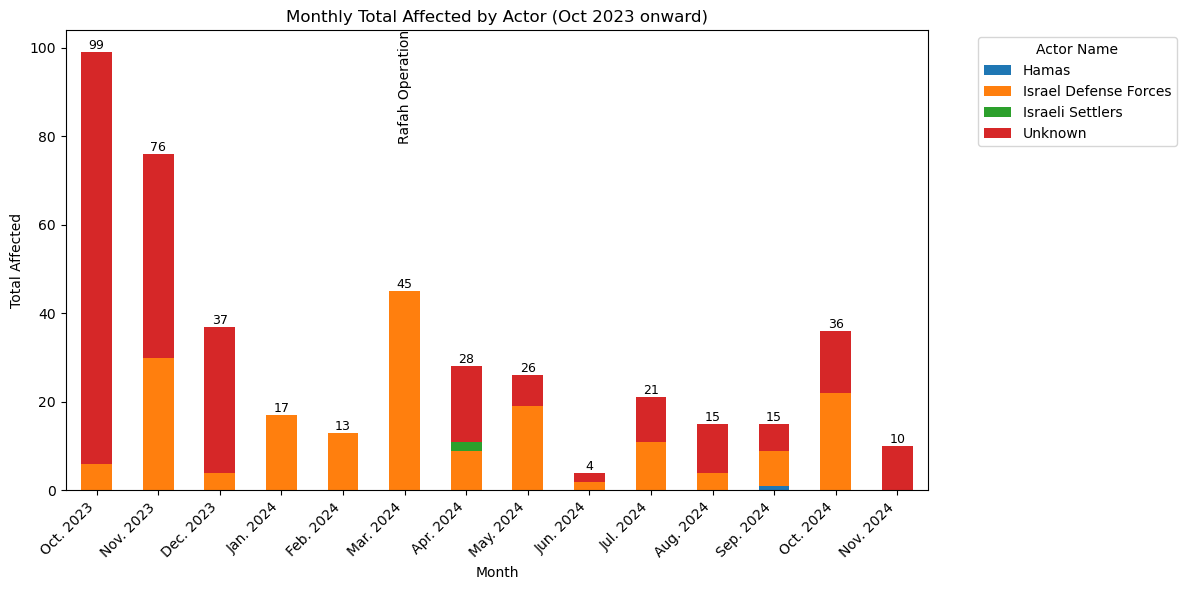

In [1006]:

# Clean and preprocess the dataset

# Convert 'Year', 'Month', and 'Total affected' to numeric, and filter from October 2023 onward
kika['Year'] = pd.to_numeric(kika['Year'], errors='coerce')
kika['Month'] = pd.to_numeric(kika['Month'], errors='coerce')
kika['Total affected'] = pd.to_numeric(kika['Total affected'], errors='coerce')
kika = kika.dropna(subset=['Year', 'Month', 'Total affected'])

# Filter for October 2023 onward
filtered_kika = kika[(kika['Year'] > 2023) | ((kika['Year'] == 2023) & (kika['Month'] >= 10))].copy()
# Combine specific variations of "Israel" into "Israel Defense Forces"
filtered_kika['Actor name'] = filtered_kika['Actor name'].replace(
    [
        'Israel Defense Forces (IDF)',
        'Israeli Defence Forces (IDF)',
        'Isreali Defence Forces (IDF)'
    ],
    'Israel Defense Forces'
)
# Aggregate total affected by month and actor
filtered_kika['Date'] = pd.to_datetime(filtered_kika[['Year', 'Month']].assign(Day=1))
monthly_data = filtered_kika.groupby(['Date', 'Actor name'])['Total affected'].sum().reset_index()

# Sum up total affected by month
monthly_totals = monthly_data.groupby('Date')['Total affected'].sum().reset_index()

# Pivot for stacked bar chart by actor
pivot_data = monthly_data.pivot(index='Date', columns='Actor name', values='Total affected').fillna(0)

# Plot the bar chart
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))

# Format x-axis with month and year as 'Oct. 2023', 'Nov. 2024', etc.
ax.set_xticks(range(len(pivot_data.index)))
ax.set_xticklabels(pivot_data.index.strftime('%b. %Y'), rotation=45, ha='right')


# Add "Rafah Operation" annotation for March 2024
rafah_date = pd.to_datetime('2024-03-01')  # March 2024
if rafah_date in monthly_totals['Date'].values:
    rafah_index = monthly_totals[monthly_totals['Date'] == rafah_date].index[0]
    ax.text(rafah_index, ax.get_ylim()[1], 'Rafah Operation', color='black', ha='center', rotation = 90, va='top', fontsize=10)


# Add total labels above each bar
for i, total in enumerate(monthly_totals['Total affected']):
    ax.text(i, total, str(int(total)), ha='center', va='bottom', fontsize=9)

plt.title('Monthly Total Affected by Actor (Oct 2023 onward)')
plt.xlabel('Month')
plt.ylabel('Total Affected')
plt.legend(title='Actor Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
